In [1]:
import pandas as pd
from textblob import TextBlob
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [2]:
folder_path= 'E:\\Case Comp\\NEST\\Training\\'
# usecase_3.to_parquet(parquet_file_path, index=False)

# Load the Parquet file back into a DataFrame
usecase_3 = pd.read_csv(folder_path + "category_updated_test.csv")

usecase_3.head()

,Unnamed: 0.1,Unnamed: 0,NCT Number,Study Title,Study URL,Acronym,Brief Summary,Study Results,Conditions,Interventions,...,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,Study Status,Conditions_Category
0,0,0,NCT03162666,Patient Outcomes Using an Expandable Spacer,https://clinicaltrials.gov/study/NCT03162666,NaN,This study is a post-market clinical follow-up...,NO,Degenerative Disc Disease,DEVICE: ALTERA,...,2/28/17,11-06-20,11-06-20,5/22/17,NaN,8/23/21,"Rush University Medical Center, Chicago, Illin...",NaN,WITHDRAWN,Non-Oncology
1,1,1,NCT04312048,the Effect of Isosorbide Mononitrate in Reduci...,https://clinicaltrials.gov/study/NCT04312048,NaN,The aim of the study is to evaluate the effica...,NO,IUD Insertion Pain,DRUG: Isosorbide mononitrate|DRUG: placebo,...,4/15/20,10/25/20,11/30/20,3/18/20,NaN,1/20/21,"Ahmed Samy, Giza, 11231, Egypt",NaN,COMPLETED,Non-Oncology
2,2,2,NCT03144778,Durvalumab With or Without Tremelimumab in Tre...,https://clinicaltrials.gov/study/NCT03144778,NaN,This phase I trial studies how well durvalumab...,NO,Stage II Oropharyngeal Squamous Cell Carcinoma...,BIOLOGICAL: Durvalumab|BIOLOGICAL: Tremelimumab,...,07-12-17,3/15/21,3/15/21,05-09-17,NaN,3/18/21,"M D Anderson Cancer Center, Houston, Texas, 77...",NaN,COMPLETED,Oncology
3,3,3,NCT01592721,Radiation and Cetuximab Plus Intratumoral EGFR...,https://clinicaltrials.gov/study/NCT01592721,NaN,The incorporation of novel targeted therapies ...,YES,Squamous Cell Carcinoma|Head and Neck Cancer,BIOLOGICAL: EGFR Antisense DNA,...,2013-04,02-01-22,02-01-22,05-07-12,9/21/22,9/21/22,"University of Pittsburgh, Pittsburgh, Pennsylv...","Study Protocol and Statistical Analysis Plan, ...",COMPLETED,Oncology
4,4,4,NCT04253613,Laser Biostimulation in Periodontal Treatment,https://clinicaltrials.gov/study/NCT04253613,NaN,"The use of nonsurgical periodontal treatment, ...",NO,Periodontal Inflammation|Periodontal Diseases,NaN,...,1/15/13,6/15/14,6/15/14,02-05-20,NaN,07-06-22,NaN,NaN,COMPLETED,Non-Oncology


In [3]:
usecase_3 = usecase_3.head(500)

In [4]:
# Ensure Start Date is in datetime format
usecase_3['Start Date'] = pd.to_datetime(usecase_3['Start Date'], errors='coerce')

# Extract month and quarter, handling missing values
usecase_3['Start Month'] = usecase_3['Start Date'].dt.month.fillna(-1).astype(int).astype('category')
usecase_3['Start Quarter'] = usecase_3['Start Date'].dt.quarter.fillna(-1).astype(int).astype('category')

# Verify the changes
usecase_3[['Start Date', 'Start Month', 'Start Quarter']].head()

C:\Users\mogal\AppData\Local\Temp\ipykernel_31732\2978651323.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  usecase_3['Start Date'] = pd.to_datetime(usecase_3['Start Date'], errors='coerce')


,Start Date,Start Month,Start Quarter
0,2017-02-28,2,1
1,2020-04-15,4,2
2,2017-07-12,7,3
3,2013-04-01,4,2
4,2013-01-15,1,1


In [5]:
usecase_3 = usecase_3[['NCT Number', 'Study Title', 'Study Status',
       'Brief Summary', 'Conditions', 'Primary Outcome Measures',
       'Secondary Outcome Measures', 'Other Outcome Measures', 'Sponsor',
       'Collaborators', 'Sex', 'Age', 'Phases', 'Enrollment', 'Funder Type',
       'Study Type', 'Study Design', 'Start Month', 'Start Quarter', 'Conditions_Category', 'Locations']]
usecase_3.columns

Index(['NCT Number', 'Study Title', 'Study Status', 'Brief Summary',
       'Conditions', 'Primary Outcome Measures', 'Secondary Outcome Measures',
       'Other Outcome Measures', 'Sponsor', 'Collaborators', 'Sex', 'Age',
       'Phases', 'Enrollment', 'Funder Type', 'Study Type', 'Study Design',
       'Start Month', 'Start Quarter', 'Conditions_Category', 'Locations'],
      dtype='object')

In [6]:
usecase_3.Conditions_Category.value_counts()

Conditions_Category
Non-Oncology                  298
Other Rare or Unclassified    134
Oncology                       68
Name: count, dtype: int64

In [7]:
conditions_category_distribution = (
    usecase_3.groupby(['Conditions_Category', 'Study Status']).size()
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())
    .unstack(fill_value=0)
)
conditions_category_distribution

,Study Status,COMPLETED,SUSPENDED,TERMINATED,WITHDRAWN
Conditions_Category,Conditions_Category,,,,
Non-Oncology,Non-Oncology,92.617450,0.33557,4.697987,2.348993
Oncology,Oncology,79.411765,0.00000,14.705882,5.882353
Other Rare or Unclassified,Other Rare or Unclassified,85.820896,0.00000,8.208955,5.970149


In [8]:
usecase_3['Collaborators'].value_counts()

Collaborators
National Cancer Institute (NCI)                                          11
Canadian Institutes of Health Research (CIHR)                             4
GlaxoSmithKline                                                           3
Pfizer                                                                    2
University of Pittsburgh                                                  2
                                                                         ..
University of California, Los Angeles|National Cancer Institute (NCI)     1
The University of The West Indies                                         1
Kyowa Hakko Bio Co., Ltd.                                                 1
West Virginia University|National Cancer Institute (NCI)                  1
TPO Uganda|United States Agency for International Development (USAID)     1
Name: count, Length: 161, dtype: int64

In [9]:
# Count number of collaborators per trial
usecase_3['Num_Collaborators'] = usecase_3['Collaborators'].apply(lambda x: len(str(x).split('|')) if pd.notna(x) else 0)
# Count number of collaborators per trial
usecase_3['Num_Collaborators'] = usecase_3['Collaborators'].apply(lambda x: len(str(x).split('|')) if pd.notna(x) else 0)
# Expanded keyword-based classification
def refine_collaborator_type(collaborator):
    if pd.isna(collaborator) or collaborator.strip() == "":
        return "Unknown"

    collaborator = collaborator.lower()

    # Pharmaceutical/Biotech Companies
    if any(x in collaborator for x in ["pharma", "biotech", "therapeutics", "biosciences", "genomics", "biopharma", "life sciences", "vaccines", "therapeutics"]):
        return "Pharmaceutical/Biotech"

    # Medical Device Companies
    elif any(x in collaborator for x in ["medtech", "medical devices", "diagnostics", "boston scientific", "medtronic", "abbott", "siemens healthineers", "imaging", "st. jude medical", "stryker"]):
        return "Medical Device Company"

    # Universities & Academic Institutions
    elif any(x in collaborator for x in ["university", "college", "academy", "school of medicine", "medical school"]):
        return "University"

    # Hospitals & Medical Centers
    elif any(x in collaborator for x in ["hospital", "medical center", "health system", "clinic", "health network", "cancer center", "teaching hospital"]):
        return "Hospital/Medical Center"

    # Academic Research Centers
    elif any(x in collaborator for x in ["institute of technology", "research institute", "academic research", "broad institute", "howard hughes", "karolinska institute"]):
        return "Academic Research Institute"

    # Non-Academic Research Centers
    elif any(x in collaborator for x in ["national laboratory", "max planck", "clinical research", "research foundation"]):
        return "Non-Academic Research Institute"

    # Government & Public Health Agencies
    elif any(x in collaborator for x in ["national", "federal", "ministry of health", "nih", "fda", "cdc", "who", "government", "department of health", "european medicines agency", "health canada"]):
        return "Government"

    # Military & Defense Medical Research
    elif any(x in collaborator for x in ["military", "army", "navy", "air force", "veterans affairs", "dod", "defense", "va medical", "darpa", "us army medical research"]):
        return "Military/Defense Medical Research"

    # Non-Profit Organizations & NGOs
    elif any(x in collaborator for x in ["non-profit", "ngo", "humanitarian", "relief fund", "patient advocacy", "community group", "alzheimer's association", "parkinson's foundation"]):
        return "Non-Profit / Patient Advocacy"

    # Foundations (Funding Agencies)
    elif any(x in collaborator for x in ["foundation", "charitable trust", "funding agency", "gates foundation", "michael j. fox foundation"]):
        return "Foundation (Funding Organization)"

    # Contract Research Organizations (CROs)
    elif any(x in collaborator for x in ["quintiles", "iqvia", "parexel", "covance", "medpace", "ppd", "icon", "charles river", "syneos", "contract research"]):
        return "Contract Research Organization (CRO)"

    # Healthcare Consortia & Alliances
    elif any(x in collaborator for x in ["consortium", "partnership", "collaborative", "alliance", "global initiative"]):
        return "Healthcare Consortium/Alliance"

    # If no match, return Other
    else:
        return "Other"

# Apply classification
usecase_3['Collaborator_Type'] = usecase_3['Collaborators'].apply(refine_collaborator_type)
usecase_3.head()

,NCT Number,Study Title,Study Status,Brief Summary,Conditions,Primary Outcome Measures,Secondary Outcome Measures,Other Outcome Measures,Sponsor,Collaborators,...,Enrollment,Funder Type,Study Type,Study Design,Start Month,Start Quarter,Conditions_Category,Locations,Num_Collaborators,Collaborator_Type
0,NCT03162666,Patient Outcomes Using an Expandable Spacer,WITHDRAWN,This study is a post-market clinical follow-up...,Degenerative Disc Disease,"Change in Radiographic Analysis, Global and Se...","Complications, Surgical or device related comp...",NaN,Globus Medical Inc,NaN,...,0.0,INDUSTRY,OBSERVATIONAL,Observational Model: |Time Perspective: p,2,1,Non-Oncology,"Rush University Medical Center, Chicago, Illin...",0,Unknown
1,NCT04312048,the Effect of Isosorbide Mononitrate in Reduci...,COMPLETED,The aim of the study is to evaluate the effica...,IUD Insertion Pain,"pain during IUD insertion, intensity of patien...","duration of IUD insertion, duration of IUD ins...",NaN,Cairo University,NaN,...,110.0,OTHER,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,4,2,Non-Oncology,"Ahmed Samy, Giza, 11231, Egypt",0,Unknown
2,NCT03144778,Durvalumab With or Without Tremelimumab in Tre...,COMPLETED,This phase I trial studies how well durvalumab...,Stage II Oropharyngeal Squamous Cell Carcinoma...,"Change of CD8+ tumor infiltrating lymphocytes,...",Incidence of adverse events and serious advers...,NaN,M.D. Anderson Cancer Center,National Cancer Institute (NCI),...,39.0,OTHER,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,7,3,Oncology,"M D Anderson Cancer Center, Houston, Texas, 77...",1,Government
3,NCT01592721,Radiation and Cetuximab Plus Intratumoral EGFR...,COMPLETED,The incorporation of novel targeted therapies ...,Squamous Cell Carcinoma|Head and Neck Cancer,"Toxicity Rate, This is a 2-stage clinical tria...","Tumor Response, Clinical secondary endpoints i...",NaN,The University of Texas Health Science Center ...,University of Pittsburgh,...,6.0,OTHER,INTERVENTIONAL,Allocation: NA|Intervention Model: SINGLE_GROU...,4,2,Oncology,"University of Pittsburgh, Pittsburgh, Pennsylv...",1,University
4,NCT04253613,Laser Biostimulation in Periodontal Treatment,COMPLETED,"The use of nonsurgical periodontal treatment, ...",Periodontal Inflammation|Periodontal Diseases,"IL-1β level in GCF, IL-1β is a cytokine presen...",NaN,NaN,Ondokuz Mayıs University,NaN,...,30.0,OTHER,OBSERVATIONAL,Observational Model: |Time Perspective: p,1,1,Non-Oncology,NaN,0,Unknown


In [10]:
usecase_3.Collaborator_Type.value_counts()

Collaborator_Type
Unknown                                 321
Other                                    76
University                               48
Government                               29
Hospital/Medical Center                   8
Pharmaceutical/Biotech                    7
Foundation (Funding Organization)         6
Military/Defense Medical Research         1
Academic Research Institute               1
Non-Academic Research Institute           1
Medical Device Company                    1
Contract Research Organization (CRO)      1
Name: count, dtype: int64

In [11]:
usecase_3['Sex'] = usecase_3['Sex'].fillna('ALL')

In [12]:
usecase_3 = usecase_3.drop(columns=['Collaborators'])
usecase_3.columns

Index(['NCT Number', 'Study Title', 'Study Status', 'Brief Summary',
       'Conditions', 'Primary Outcome Measures', 'Secondary Outcome Measures',
       'Other Outcome Measures', 'Sponsor', 'Sex', 'Age', 'Phases',
       'Enrollment', 'Funder Type', 'Study Type', 'Study Design',
       'Start Month', 'Start Quarter', 'Conditions_Category', 'Locations',
       'Num_Collaborators', 'Collaborator_Type'],
      dtype='object')

In [13]:
missing_count = usecase_3.isnull().sum()

# Percentage of missing values in each column
missing_percentage = (missing_count / len(usecase_3)) * 100

# Combine into a single DataFrame for better readability
missing_summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage (%)': missing_percentage
})
missing_summary

,Missing Count,Missing Percentage (%)
NCT Number,0,0.0
Study Title,0,0.0
Study Status,0,0.0
Brief Summary,0,0.0
Conditions,0,0.0
Primary Outcome Measures,16,3.2
Secondary Outcome Measures,142,28.4
Other Outcome Measures,464,92.8
Sponsor,0,0.0
Sex,0,0.0


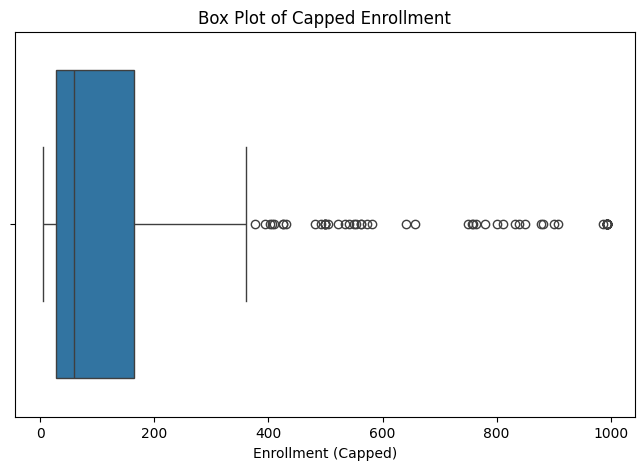

In [14]:
# Define IQR-based outlier capping function
def cap_outliers(series, lower_percentile=0.05, upper_percentile=0.95):
    lower_bound = np.percentile(series.dropna(), lower_percentile * 100)
    upper_bound = np.percentile(series.dropna(), upper_percentile * 100)
    return np.clip(series, lower_bound, upper_bound)

# Cap outliers in Enrollment column
usecase_3['Enrollment_Capped'] = cap_outliers(usecase_3['Enrollment'])

# Create a box plot for Enrollment after capping outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=usecase_3['Enrollment_Capped'])

# Set title and labels
plt.title('Box Plot of Capped Enrollment')
plt.xlabel('Enrollment (Capped)')

# Show plot
plt.show()

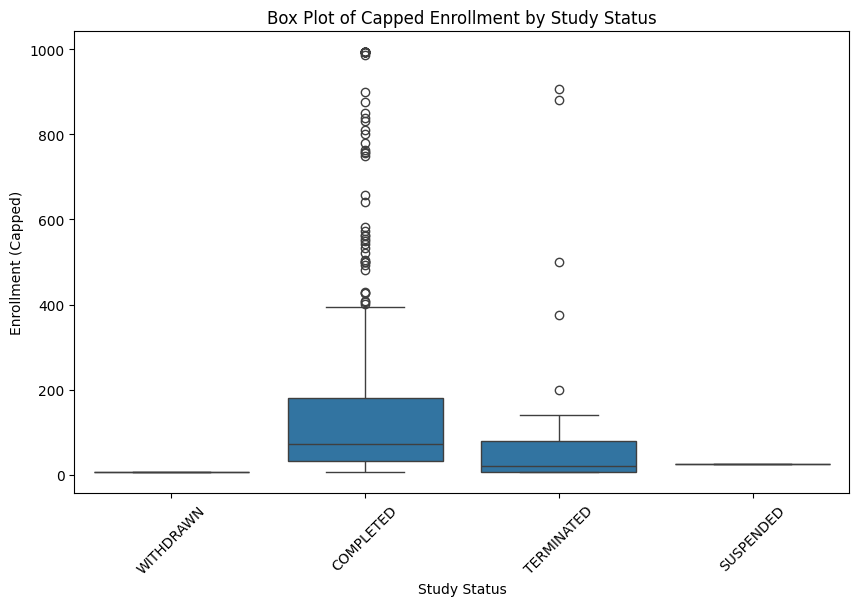

In [15]:
# Check if the dataset is available before proceeding
if 'usecase_3' in locals():
    # Group by Study Status and apply outlier capping on Enrollment
    usecase_3['Enrollment_Capped'] = cap_outliers(usecase_3['Enrollment'])

    # Create a box plot for Enrollment categorized by Study Status
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=usecase_3['Study Status'], y=usecase_3['Enrollment_Capped'])

    # Set title and labels
    plt.title('Box Plot of Capped Enrollment by Study Status')
    plt.xlabel('Study Status')
    plt.ylabel('Enrollment (Capped)')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    # Show plot
    plt.show()
else:
    print("Dataset 'usecase_3' not found. Please upload the dataset.")

In [16]:
# Calculate percentage of missing Enrollment by Study Status
missing_enrollment_pct = usecase_3.groupby('Study Status')['Enrollment'].apply(lambda x: x.isna().mean() * 100)

# Convert to DataFrame for better visualization
missing_enrollment_df = missing_enrollment_pct.reset_index().rename(columns={'Enrollment': 'Missing Enrollment (%)'})

# Display the result
print(missing_enrollment_df)

  Study Status  Missing Enrollment (%)
0    COMPLETED                1.573034
1    SUSPENDED                0.000000
2   TERMINATED                2.857143
3    WITHDRAWN                0.000000


In [17]:
# Calculate median enrollment for each Study Status group
median_enrollment = usecase_3.groupby('Study Status')['Enrollment'].median()

# Fill missing values using the median of the respective Study Status group
usecase_3['Enrollment'] = usecase_3.apply(
    lambda row: median_enrollment[row['Study Status']] if pd.isna(row['Enrollment']) else row['Enrollment'], axis=1
)

In [18]:
# usecase_3 = usecase_3.dropna(subset=['Primary Outcome Measures'])

In [19]:
# Combine the text from the three columns, handling missing values
usecase_3['Total Outcome Measures'] = usecase_3[['Primary Outcome Measures', 'Secondary Outcome Measures', 'Other Outcome Measures']].apply(
    lambda row: ' | '.join(row.dropna().astype(str)), axis=1
)

# Drop the original columns
usecase_3.drop(columns=['Primary Outcome Measures', 'Secondary Outcome Measures', 'Other Outcome Measures'], inplace=True)

# Verify the changes
usecase_3[['Total Outcome Measures']].head()

,Total Outcome Measures
0,"Change in Radiographic Analysis, Global and Se..."
1,"pain during IUD insertion, intensity of patien..."
2,"Change of CD8+ tumor infiltrating lymphocytes,..."
3,"Toxicity Rate, This is a 2-stage clinical tria..."
4,"IL-1β level in GCF, IL-1β is a cytokine presen..."


In [20]:
usecase_3.drop(columns=['Enrollment_Capped'], inplace=True)

In [21]:
missing_count = usecase_3.isnull().sum()

# Percentage of missing values in each column
missing_percentage = (missing_count / len(usecase_3)) * 100

# Combine into a single DataFrame for better readability
missing_summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage (%)': missing_percentage
})
missing_summary

,Missing Count,Missing Percentage (%)
NCT Number,0,0.0
Study Title,0,0.0
Study Status,0,0.0
Brief Summary,0,0.0
Conditions,0,0.0
Sponsor,0,0.0
Sex,0,0.0
Age,0,0.0
Phases,272,54.4
Enrollment,0,0.0


In [22]:
# Lists of columns
columns_mode = ['Age', 'Sex']
columns_unknown = ['Funder Type', 'Study Type', 'Study Design', 'Total Outcome Measures']

# Fill numerical columns with median
for col in columns_mode:
    mode_value = usecase_3[col].mode()
    usecase_3[col].fillna(mode_value, inplace=True)

# Fill categorical columns with 'unknown'
for col in columns_unknown:
    usecase_3[col].fillna('Unknown', inplace=True)

In [23]:
pd.DataFrame(usecase_3.Conditions.value_counts()).head(50)

,count
Conditions,
Healthy,8
Breast Cancer,5
Obesity,4
Type 2 Diabetes,4
Prostate Cancer,3
HIV Infections,3
Chronic Hepatitis C,3
Schizophrenia,3
Acne Vulgaris,3


In [24]:
# Define a function to classify conditions with detailed categories
def classify_condition(condition):
    if pd.isnull(condition):
        return 'Unknown'

    condition_lower = condition.lower()

    # Cancer-related conditions
    if any(keyword in condition_lower for keyword in ['cancer', 'tumor', 'carcinoma', 'lymphoma', 'leukemia', 'melanoma']):
        return 'Cancer'

    # Cardiovascular diseases
    if any(keyword in condition_lower for keyword in ['heart', 'cardio', 'vascular', 'stroke', 'artery', 'hypertension', 'atrial']):
        return 'Cardiovascular'

    # Neurological disorders
    if any(keyword in condition_lower for keyword in ['brain', 'neuro', 'alzheimer', 'parkinson', 'epilepsy', 'multiple sclerosis']):
        return 'Neurological'

    # Infectious diseases
    if any(keyword in condition_lower for keyword in ['infection', 'virus', 'bacterial', 'hiv', 'malaria', 'covid', 'influenza']):
        return 'Infectious Diseases'

    # Endocrine and metabolic disorders
    if any(keyword in condition_lower for keyword in ['diabetes', 'thyroid', 'obesity', 'metabolic', 'insulin']):
        return 'Endocrine/Metabolic'

    # Respiratory conditions
    if any(keyword in condition_lower for keyword in ['asthma', 'lung', 'copd', 'pulmonary']):
        return 'Respiratory'

    # Gastrointestinal & Hepatic diseases
    if any(keyword in condition_lower for keyword in ['liver', 'hepatic', 'pancreatic', 'colorectal', 'gastro']):
        return 'Gastrointestinal & Hepatic'

    # Autoimmune and inflammatory conditions
    if any(keyword in condition_lower for keyword in ['arthritis', 'rheumatoid', 'psoriasis', 'inflammatory', 'lupus', 'crohn']):
        return 'Autoimmune & Inflammatory'

    # Musculoskeletal disorders
    if any(keyword in condition_lower for keyword in ['osteoporosis', 'osteoarthritis', 'fracture', 'spine', 'back pain', 'knee']):
        return 'Musculoskeletal'

    # Psychiatric & behavioral disorders
    if any(keyword in condition_lower for keyword in ['schizophrenia', 'bipolar', 'depression', 'psychiatric', 'mental health']):
        return 'Psychiatric & Behavioral'

    # Reproductive & urological disorders
    if any(keyword in condition_lower for keyword in ['infertility', 'prostate', 'kidney', 'renal', 'bladder', 'reproductive']):
        return 'Reproductive & Urological'

    # General health & other
    if any(keyword in condition_lower for keyword in ['healthy', 'general health', 'volunteers']):
        return 'General Health & Others'

    # Default to "Other" for unspecified conditions
    return 'Other'

# Apply the improved classification function
usecase_3['Condition_Category_old'] = usecase_3['Conditions'].apply(classify_condition)

# Verify results
usecase_3[['Conditions', 'Condition_Category_old']].head(20)

,Conditions,Condition_Category_old
0,Degenerative Disc Disease,Other
1,IUD Insertion Pain,Other
2,Stage II Oropharyngeal Squamous Cell Carcinoma...,Cancer
3,Squamous Cell Carcinoma|Head and Neck Cancer,Cancer
4,Periodontal Inflammation|Periodontal Diseases,Other
5,Peripheral Artery Disease,Cardiovascular
6,Cardiovascular Risk Factor|Heart Diseases|Infl...,Cardiovascular
7,Healthy,General Health & Others
8,Parkinson's Disease|With Inclusion Criteria fo...,Neurological
9,Urinary Tract Infections,Infectious Diseases


In [25]:
usecase_3.Condition_Category_old.value_counts()

Condition_Category_old
Other                         243
Cancer                         63
Infectious Diseases            35
Cardiovascular                 33
Endocrine/Metabolic            33
General Health & Others        20
Neurological                   19
Respiratory                    13
Reproductive & Urological      12
Autoimmune & Inflammatory       8
Musculoskeletal                 7
Psychiatric & Behavioral        7
Gastrointestinal & Hepatic      7
Name: count, dtype: int64

In [26]:
usecase_3.drop(columns=['Conditions'], inplace=True)

In [27]:
# Define a function to classify sponsors
def classify_sponsor(sponsor):
    if pd.isnull(sponsor):
        return 'Unknown'
    sponsor_lower = sponsor.lower()

    # University
    if 'university' in sponsor_lower or 'school of medicine' in sponsor_lower:
        return 'University'

    # Hospital or Clinic
    if 'hospital' in sponsor_lower or 'clinic' in sponsor_lower or 'center' in sponsor_lower:
        return 'Hospital/Clinic'

    # Company
    company_keywords = ['pharmaceuticals', 'biopharma', 'biosciences', 'llc', 'inc',
                         'company', 'a/s', 'ltd', 'plc', 'corporation']
    if any(keyword in sponsor_lower for keyword in company_keywords):
        return 'Company'

    # Government Institute
    gov_keywords = ['national', 'institute', 'office of research', 'va', 'nci', 'niaid']
    if any(keyword in sponsor_lower for keyword in gov_keywords):
        return 'Government Institute'

    # Other
    return 'Other'

# Apply the classification function to the Sponsor column
usecase_3['Sponsor Type'] = usecase_3['Sponsor'].apply(classify_sponsor)
usecase_3.drop(columns=['Sponsor'], inplace=True)
# Verify the distribution of Sponsor Type
print(usecase_3['Sponsor Type'].value_counts())

Sponsor Type
University              190
Other                   144
Hospital/Clinic          75
Company                  59
Government Institute     32
Name: count, dtype: int64


In [28]:
usecase_3.columns

Index(['NCT Number', 'Study Title', 'Study Status', 'Brief Summary', 'Sex',
       'Age', 'Phases', 'Enrollment', 'Funder Type', 'Study Type',
       'Study Design', 'Start Month', 'Start Quarter', 'Conditions_Category',
       'Locations', 'Num_Collaborators', 'Collaborator_Type',
       'Total Outcome Measures', 'Condition_Category_old', 'Sponsor Type'],
      dtype='object')

In [29]:
# Define the unique age categories
age_categories = ['CHILD', 'ADULT', 'OLDER_ADULT']

# Create binary columns for each age group
for category in age_categories:
    usecase_3[category] = usecase_3['Age'].apply(lambda x: 1 if isinstance(x, str) and category in x else 0)

# Drop the original 'Age' column
usecase_3.drop(columns=['Age'], inplace=True)

# Display the modified DataFrame
usecase_3.head()

,NCT Number,Study Title,Study Status,Brief Summary,Sex,Phases,Enrollment,Funder Type,Study Type,Study Design,...,Conditions_Category,Locations,Num_Collaborators,Collaborator_Type,Total Outcome Measures,Condition_Category_old,Sponsor Type,CHILD,ADULT,OLDER_ADULT
0,NCT03162666,Patient Outcomes Using an Expandable Spacer,WITHDRAWN,This study is a post-market clinical follow-up...,ALL,NaN,0.0,INDUSTRY,OBSERVATIONAL,Observational Model: |Time Perspective: p,...,Non-Oncology,"Rush University Medical Center, Chicago, Illin...",0,Unknown,"Change in Radiographic Analysis, Global and Se...",Other,Company,0,1,1
1,NCT04312048,the Effect of Isosorbide Mononitrate in Reduci...,COMPLETED,The aim of the study is to evaluate the effica...,FEMALE,PHASE3,110.0,OTHER,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,...,Non-Oncology,"Ahmed Samy, Giza, 11231, Egypt",0,Unknown,"pain during IUD insertion, intensity of patien...",Other,University,1,1,1
2,NCT03144778,Durvalumab With or Without Tremelimumab in Tre...,COMPLETED,This phase I trial studies how well durvalumab...,ALL,PHASE1,39.0,OTHER,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,...,Oncology,"M D Anderson Cancer Center, Houston, Texas, 77...",1,Government,"Change of CD8+ tumor infiltrating lymphocytes,...",Cancer,Hospital/Clinic,0,1,1
3,NCT01592721,Radiation and Cetuximab Plus Intratumoral EGFR...,COMPLETED,The incorporation of novel targeted therapies ...,ALL,PHASE1|PHASE2,6.0,OTHER,INTERVENTIONAL,Allocation: NA|Intervention Model: SINGLE_GROU...,...,Oncology,"University of Pittsburgh, Pittsburgh, Pennsylv...",1,University,"Toxicity Rate, This is a 2-stage clinical tria...",Cancer,University,0,1,1
4,NCT04253613,Laser Biostimulation in Periodontal Treatment,COMPLETED,"The use of nonsurgical periodontal treatment, ...",MALE,NaN,30.0,OTHER,OBSERVATIONAL,Observational Model: |Time Perspective: p,...,Non-Oncology,NaN,0,Unknown,"IL-1β level in GCF, IL-1β is a cytokine presen...",Other,University,0,1,1


In [30]:
usecase_3['Study Design'].value_counts().head(50)

Study Design
Observational Model: |Time Perspective: p                                                                                                                               102
Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: NONE|Primary Purpose: TREATMENT                                                                             47
Allocation: NA|Intervention Model: SINGLE_GROUP|Masking: NONE|Primary Purpose: TREATMENT                                                                                 40
Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: QUADRUPLE (PARTICIPANT, CARE_PROVIDER, INVESTIGATOR, OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT          36
Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (PARTICIPANT, INVESTIGATOR)|Primary Purpose: TREATMENT                                               18
Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: NONE|Primary Purpose: PREVENTION                                  

In [31]:
# Function to extract attribute values
def extract_attribute(study_design, attribute):
    if pd.isnull(study_design):
        return None
    for part in study_design.split('|'):
        if attribute in part:
            return part.split(':')[1].strip() if ':' in part else None
    return None

# Extract key features
usecase_3['Allocation'] = usecase_3['Study Design'].apply(lambda x: extract_attribute(x, 'Allocation'))
usecase_3['Intervention Model'] = usecase_3['Study Design'].apply(lambda x: extract_attribute(x, 'Intervention Model'))
usecase_3['Masking'] = usecase_3['Study Design'].apply(lambda x: extract_attribute(x, 'Masking'))
usecase_3['Primary Purpose'] = usecase_3['Study Design'].apply(lambda x: extract_attribute(x, 'Primary Purpose'))
usecase_3['Observational Model'] = usecase_3['Study Design'].apply(lambda x: extract_attribute(x, 'Observational Model'))
usecase_3['Time Perspective'] = usecase_3['Study Design'].apply(lambda x: extract_attribute(x, 'Time Perspective'))

# Extract Masking Level
def extract_masking_level(masking):
    if pd.isnull(masking):
        return 'NONE'
    if 'QUADRUPLE' in masking:
        return 'QUADRUPLE'
    if 'TRIPLE' in masking:
        return 'TRIPLE'
    if 'DOUBLE' in masking:
        return 'DOUBLE'
    if 'SINGLE' in masking:
        return 'SINGLE'
    return 'NONE'

usecase_3['Masking Level'] = usecase_3['Masking'].apply(extract_masking_level)

# Extract Masking Details
def extract_masking_details(masking):
    if pd.isnull(masking):
        return 'NONE'
    if '(' in masking:
        return masking.split('(')[1].strip(')')
    return 'NONE'

usecase_3['Masking Details'] = usecase_3['Masking'].apply(extract_masking_details)

# Handle missing values by filling with 'Unknown'
usecase_3['Allocation'].fillna('Unknown', inplace=True)
usecase_3['Intervention Model'].fillna('Unknown', inplace=True)
usecase_3['Primary Purpose'].fillna('Unknown', inplace=True)
usecase_3['Observational Model'].fillna('Unknown', inplace=True)
usecase_3['Time Perspective'].fillna('Unknown', inplace=True)

# One-hot encode categorical features
usecase_3 = pd.get_dummies(
    usecase_3,
    columns=['Allocation', 'Intervention Model', 'Masking Level', 'Primary Purpose']
)

# Drop original 'Study Design' column
# usecase_3.drop(columns=['Study Design'], inplace=True)
usecase_3.head()

,NCT Number,Study Title,Study Status,Brief Summary,Sex,Phases,Enrollment,Funder Type,Study Type,Study Design,...,Primary Purpose_,Primary Purpose_BASIC_SCIENCE,Primary Purpose_DIAGNOSTIC,Primary Purpose_HEALTH_SERVICES_RESEARCH,Primary Purpose_OTHER,Primary Purpose_PREVENTION,Primary Purpose_SCREENING,Primary Purpose_SUPPORTIVE_CARE,Primary Purpose_TREATMENT,Primary Purpose_Unknown
0,NCT03162666,Patient Outcomes Using an Expandable Spacer,WITHDRAWN,This study is a post-market clinical follow-up...,ALL,NaN,0.0,INDUSTRY,OBSERVATIONAL,Observational Model: |Time Perspective: p,...,False,False,False,False,False,False,False,False,False,True
1,NCT04312048,the Effect of Isosorbide Mononitrate in Reduci...,COMPLETED,The aim of the study is to evaluate the effica...,FEMALE,PHASE3,110.0,OTHER,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,...,False,False,False,False,False,True,False,False,False,False
2,NCT03144778,Durvalumab With or Without Tremelimumab in Tre...,COMPLETED,This phase I trial studies how well durvalumab...,ALL,PHASE1,39.0,OTHER,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,...,False,False,False,False,False,False,False,False,True,False
3,NCT01592721,Radiation and Cetuximab Plus Intratumoral EGFR...,COMPLETED,The incorporation of novel targeted therapies ...,ALL,PHASE1|PHASE2,6.0,OTHER,INTERVENTIONAL,Allocation: NA|Intervention Model: SINGLE_GROU...,...,False,False,False,False,False,False,False,False,True,False
4,NCT04253613,Laser Biostimulation in Periodontal Treatment,COMPLETED,"The use of nonsurgical periodontal treatment, ...",MALE,NaN,30.0,OTHER,OBSERVATIONAL,Observational Model: |Time Perspective: p,...,False,False,False,False,False,False,False,False,False,True


In [32]:
# Fill NaN values with empty strings before concatenation
usecase_3['Combined_Text'] = (
    usecase_3['Study Title'].fillna('') + ' ' +
    usecase_3['Brief Summary'].fillna('') + ' ' +
    usecase_3['Total Outcome Measures'].fillna('')
)

In [33]:
# Download wordnet and stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')  # Required for wordnet lemmatizer
nltk.download('stopwords')  # Ensure stopwords are available

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mogal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mogal\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mogal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
# Download necessary resources
nltk.download('punkt')  # Tokenizer
nltk.download('averaged_perceptron_tagger')  # POS tagging
nltk.download('wordnet')  # Lemmatization
nltk.download('stopwords')  # Stopwords
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mogal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mogal\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mogal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mogal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mogal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [35]:
list(usecase_3.columns)

['NCT Number',
 'Study Title',
 'Study Status',
 'Brief Summary',
 'Sex',
 'Phases',
 'Enrollment',
 'Funder Type',
 'Study Type',
 'Study Design',
 'Start Month',
 'Start Quarter',
 'Conditions_Category',
 'Locations',
 'Num_Collaborators',
 'Collaborator_Type',
 'Total Outcome Measures',
 'Condition_Category_old',
 'Sponsor Type',
 'CHILD',
 'ADULT',
 'OLDER_ADULT',
 'Masking',
 'Observational Model',
 'Time Perspective',
 'Masking Details',
 'Allocation_',
 'Allocation_NA',
 'Allocation_NON_RANDOMIZED',
 'Allocation_RANDOMIZED',
 'Allocation_Unknown',
 'Intervention Model_',
 'Intervention Model_CROSSOVER',
 'Intervention Model_FACTORIAL',
 'Intervention Model_PARALLEL',
 'Intervention Model_SEQUENTIAL',
 'Intervention Model_SINGLE_GROUP',
 'Intervention Model_Unknown',
 'Masking Level_DOUBLE',
 'Masking Level_NONE',
 'Masking Level_QUADRUPLE',
 'Masking Level_SINGLE',
 'Masking Level_TRIPLE',
 'Primary Purpose_',
 'Primary Purpose_BASIC_SCIENCE',
 'Primary Purpose_DIAGNOSTIC',
 'Pr

In [36]:
# List of 195 countries from the dataset
country_list = [
    "India", "China", "United States", "Indonesia", "Pakistan", "Nigeria", "Brazil", "Bangladesh", "Russia",
    "Ethiopia", "Mexico", "Japan", "Egypt", "Philippines", "DR Congo", "Vietnam", "Iran", "Turkey", "Germany",
    "Thailand", "United Kingdom", "Tanzania", "France", "South Africa", "Italy", "Kenya", "Myanmar", "Colombia",
    "Korea", "Sudan", "Uganda", "Spain", "Algeria", "Iraq", "Argentina", "Afghanistan", "Yemen", "Canada",
    "Poland", "Morocco", "Angola", "Ukraine", "Uzbekistan", "Malaysia", "Mozambique", "Ghana", "Peru", "Saudi Arabia",
    "Madagascar", "Côte D'Ivoire", "Nepal", "Cameroon", "Venezuela", "Niger", "Australia", "North Korea", "Syria",
    "Mali", "Burkina Faso", "Sri Lanka", "Malawi", "Zambia", "Kazakhstan", "Chad", "Chile", "Romania", "Somalia",
    "Senegal", "Guatemala", "Netherlands", "Ecuador", "Cambodia", "Zimbabwe", "Guinea", "Benin", "Rwanda", "Burundi",
    "Bolivia", "Tunisia", "South Sudan", "Haiti", "Belgium", "Jordan", "Dominican Republic", "United Arab Emirates",
    "Cuba", "Honduras", "Czech Republic", "Sweden", "Tajikistan", "Papua New Guinea", "Portugal", "Azerbaijan",
    "Greece", "Hungary", "Togo", "Israel", "Austria", "Belarus", "Switzerland", "Sierra Leone", "Laos", "Turkmenistan",
    "Libya", "Kyrgyzstan", "Paraguay", "Nicaragua", "Bulgaria", "Serbia", "El Salvador", "Congo", "Denmark",
    "Singapore", "Lebanon", "Finland", "Liberia", "Norway", "Slovakia", "State of Palestine",
    "Central African Republic", "Oman", "Ireland", "New Zealand", "Mauritania", "Costa Rica", "Kuwait", "Panama",
    "Croatia", "Georgia", "Eritrea", "Mongolia", "Uruguay", "Bosnia and Herzegovina", "Qatar", "Moldova", "Namibia",
    "Armenia", "Lithuania", "Jamaica", "Albania", "Gambia", "Gabon", "Botswana", "Lesotho", "Guinea-Bissau",
    "Slovenia", "Equatorial Guinea", "Latvia", "North Macedonia", "Bahrain", "Trinidad and Tobago", "Timor-Leste",
    "Estonia", "Cyprus", "Mauritius", "Eswatini", "Djibouti", "Fiji", "Comoros", "Guyana", "Solomon Islands",
    "Bhutan", "Luxembourg", "Montenegro", "Suriname", "Malta", "Maldives", "Micronesia", "Cabo Verde", "Brunei",
    "Belize", "Bahamas", "Iceland", "Vanuatu", "Barbados", "Sao Tome & Principe", "Samoa", "Saint Lucia", "Kiribati",
    "Seychelles", "Grenada", "Tonga", "St. Vincent & Grenadines", "Antigua and Barbuda", "Andorra", "Dominica",
    "Saint Kitts & Nevis", "Liechtenstein", "Monaco", "Marshall Islands", "San Marino", "Palau", "Nauru", "Tuvalu",
    "Holy See","Taiwan","Hong Kong","Czechia","Puerto Rico","Palestinian Territory","Swaziland","Faroe Islands","Réunion","Yugoslavia","French Guiana","Lao People's Democratic Republic","The Former Yugoslav Republic of","GSK Investigational Site","Guadeloupe","French Polynesia","Kosovo","Macau","Guam","Greenland","Saint Kitts and Nevis", "New Caledonia", "Northern Mariana Islands", "New Caledonia", "Novartis Investigative Site", "Palestinian Territories", "Cayman Islands"
]


# Function to extract state and country from location text
def extract_state_country(location):
    location = str(location)  # Ensure it's a string
    country = None
    state = None

    # Extract country from location text
    for c in country_list:
        if c in location:
            country = c
            break

    # Extract state (for US locations)
    location_parts = re.split(r'[|,]', location)  # Split by '|' or ','
    for part in location_parts:
        part = part.strip()
    return country

# Apply function to extract state and country
usecase_3[['Country']] = usecase_3['Locations'].apply(lambda x: pd.Series(extract_state_country(x)))

# Display results
usecase_3.head()

,NCT Number,Study Title,Study Status,Brief Summary,Sex,Phases,Enrollment,Funder Type,Study Type,Study Design,...,Primary Purpose_DIAGNOSTIC,Primary Purpose_HEALTH_SERVICES_RESEARCH,Primary Purpose_OTHER,Primary Purpose_PREVENTION,Primary Purpose_SCREENING,Primary Purpose_SUPPORTIVE_CARE,Primary Purpose_TREATMENT,Primary Purpose_Unknown,Combined_Text,Country
0,NCT03162666,Patient Outcomes Using an Expandable Spacer,WITHDRAWN,This study is a post-market clinical follow-up...,ALL,NaN,0.0,INDUSTRY,OBSERVATIONAL,Observational Model: |Time Perspective: p,...,False,False,False,False,False,False,False,True,Patient Outcomes Using an Expandable Spacer Th...,United States
1,NCT04312048,the Effect of Isosorbide Mononitrate in Reduci...,COMPLETED,The aim of the study is to evaluate the effica...,FEMALE,PHASE3,110.0,OTHER,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,...,False,False,False,True,False,False,False,False,the Effect of Isosorbide Mononitrate in Reduci...,Egypt
2,NCT03144778,Durvalumab With or Without Tremelimumab in Tre...,COMPLETED,This phase I trial studies how well durvalumab...,ALL,PHASE1,39.0,OTHER,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,...,False,False,False,False,False,False,True,False,Durvalumab With or Without Tremelimumab in Tre...,United States
3,NCT01592721,Radiation and Cetuximab Plus Intratumoral EGFR...,COMPLETED,The incorporation of novel targeted therapies ...,ALL,PHASE1|PHASE2,6.0,OTHER,INTERVENTIONAL,Allocation: NA|Intervention Model: SINGLE_GROU...,...,False,False,False,False,False,False,True,False,Radiation and Cetuximab Plus Intratumoral EGFR...,United States
4,NCT04253613,Laser Biostimulation in Periodontal Treatment,COMPLETED,"The use of nonsurgical periodontal treatment, ...",MALE,NaN,30.0,OTHER,OBSERVATIONAL,Observational Model: |Time Perspective: p,...,False,False,False,False,False,False,False,True,Laser Biostimulation in Periodontal Treatment ...,NaN


In [37]:
usecase_3.Country.isna().sum()

38

In [38]:
usecase_3.Country.isnull().sum()

38

In [39]:
usecase_3.Country.value_counts()

Country
United States           189
France                   26
Canada                   22
India                    21
China                    21
Turkey                   18
Italy                    17
Germany                  16
Korea                    11
Egypt                    10
Spain                    10
Taiwan                    8
United Kingdom            7
Switzerland               7
Netherlands               6
Brazil                    6
Thailand                  6
Denmark                   4
Israel                    4
Austria                   3
Norway                    3
Romania                   3
Japan                     3
Finland                   3
Malaysia                  3
Belgium                   3
Sweden                    2
Australia                 2
Czechia                   2
Vietnam                   2
Singapore                 2
Mexico                    2
Pakistan                  2
Iran                      1
Saudi Arabia              1
United Arab 

In [40]:
usecase_3.Country.fillna('Unknown', inplace=True)

In [41]:
developed = [
    "United States", "Canada", "Germany", "Japan", "United Kingdom", "France", "Switzerland",
    "Netherlands", "Sweden", "Denmark", "Norway", "Finland", "Australia", "New Zealand", "Belgium",
    "Austria", "Ireland", "Singapore", "Hong Kong", "Taiwan", "Israel", "Luxembourg",
    "Iceland", "Czech Republic", "Estonia", "Slovenia", "Portugal","Spain", "Italy", "Czechia", "Korea"
]

developing = [
    "India", "China", "Brazil", "Russia", "Mexico", "South Africa", "Indonesia", "Malaysia", "Turkey",
    "Argentina", "Thailand", "Vietnam", "Chile", "Colombia", "Poland", "Hungary", "Slovakia", "Lithuania",
    "Latvia", "Kazakhstan", "Bulgaria", "Romania", "Peru", "Uruguay", "Panama", "United Arab Emirates",
    "Costa Rica", "Qatar", "Oman", "Saudi Arabia", "Malta", "Bahrain", "Kuwait","Egypt", "Pakistan", "Ethiopia", "Iraq", "Kenya", "Jordan", "Iran",
    "Cameroon", "Greece", "Philippines", "Tanzania", "Kyrgyzstan", "Senegal", "Tunisia",
    "Belarus", "Croatia", "Cyprus", "Lebanon", "Ghana", "Mauritius", "Jamaica", "Uganda",
    "Serbia", "Armenia", "Guatemala", "Ukraine", "Nigeria", "Algeria", "Cuba", "Bolivia",
    "El Salvador", "Bosnia and Herzegovina", "Venezuela", "Moldova", "Georgia", "Paraguay",
    "Botswana", "Morocco", "Sri Lanka", "Trinidad and Tobago", "Brunei", "Uzbekistan",
    "Honduras", "Ecuador", "Bhutan", "Montenegro", "Albania", "Fiji", "Bahamas", "Suriname",
    "North Macedonia", "Nicaragua", "Mongolia", "Azerbaijan"
]

underdeveloped = [
    "Afghanistan", "Yemen", "Sudan", "Chad", "Somalia", "South Sudan", "Democratic Republic of Congo",
    "Haiti", "Burundi", "Liberia", "Sierra Leone", "Mozambique", "Madagascar", "Central African Republic",
    "Eritrea", "Niger", "Mali", "Burkina Faso", "Guinea", "Guinea-Bissau", "Gambia", "Comoros", "Zambia",
    "Zimbabwe", "Nepal", "Bangladesh", "Myanmar", "Papua New Guinea", "Rwanda", "Congo", "Syria", "Malawi", "Benin", "Gabon", "Cambodia", "Lesotho", "Dominican Republic",
    "Lao People's Democratic Republic", "Namibia", "Guyana", "Libya"
]
#Other Institutions (Territories, Former Countries, and Research Sites)
other_institutions = [
    "Puerto Rico", "Palestinian Territory", "Réunion", "French Guiana", "Macau", "Guadeloupe",
    "Kosovo", "Guam", "Greenland", "French Polynesia", "Faroe Islands", "Saint Kitts and Nevis",
    "Andorra", "San Marino", "Micronesia", "Solomon Islands", "Vanuatu", "Samoa", "Saint Lucia",
    "Grenada", "Barbados", "Antigua and Barbuda", "Liechtenstein", "GSK Investigational Site",
    "Yugoslavia", "The Former Yugoslav Republic of", "New Caledonia", "Northern Mariana Islands", "New Caledonia", "Novartis Investigative Site", "Palestinian Territories", "Cayman Islands","Monaco", "Côte D'Ivoire", "Swaziland"
]


# Define category mappings
def categorize_country(country):
    if country in developed:
        return "Developed"
    elif country in developing:
        return "Developing"
    elif country in underdeveloped:
        return "Underdeveloped"
    elif country in other_institutions:
        return "Other Institutions"
    else:
        return "Unknown"

# Apply country categorization
usecase_3['Development Category'] = usecase_3['Country'].apply(categorize_country)

In [42]:
usecase_3['Development Category'].isna().sum()

0

In [43]:
usecase_3['Development Category'].isnull().sum()

0

In [44]:
# Function to compute linguistic features
def extract_text_features(text):
    if pd.isnull(text) or text.strip() == '':
        return pd.Series([0, 0, 0, 0, 0])  # Handle missing values

    # Word Count
    word_count = len(text.split())

    # Character Count (excluding spaces)
    char_count = len(text.replace(" ", ""))

    # Sentence Count (Using TextBlob instead of nltk)
    sentence_count = len(TextBlob(text).sentences)

    # Average Word Length
    avg_word_length = char_count / word_count if word_count > 0 else 0

    # Sentiment Score
    sentiment = TextBlob(text).sentiment.polarity

    return pd.Series([word_count, char_count, sentence_count, avg_word_length, sentiment])

# Apply feature extraction to each column
for col in ['Study Title', 'Brief Summary', 'Total Outcome Measures']:
    feature_names = [f"{col}_Word_Count", f"{col}_Char_Count", f"{col}_Sentence_Count",
                     f"{col}_Avg_Word_Length", f"{col}_Sentiment_Score"]

    usecase_3[feature_names] = usecase_3[col].apply(extract_text_features)

# Verify the extracted features
usecase_3.head()

,NCT Number,Study Title,Study Status,Brief Summary,Sex,Phases,Enrollment,Funder Type,Study Type,Study Design,...,Brief Summary_Word_Count,Brief Summary_Char_Count,Brief Summary_Sentence_Count,Brief Summary_Avg_Word_Length,Brief Summary_Sentiment_Score,Total Outcome Measures_Word_Count,Total Outcome Measures_Char_Count,Total Outcome Measures_Sentence_Count,Total Outcome Measures_Avg_Word_Length,Total Outcome Measures_Sentiment_Score
0,NCT03162666,Patient Outcomes Using an Expandable Spacer,WITHDRAWN,This study is a post-market clinical follow-up...,ALL,NaN,0.0,INDUSTRY,OBSERVATIONAL,Observational Model: |Time Perspective: p,...,28.0,156.0,2.0,5.571429,0.000000,110.0,757.0,1.0,6.881818,0.000000
1,NCT04312048,the Effect of Isosorbide Mononitrate in Reduci...,COMPLETED,The aim of the study is to evaluate the effica...,FEMALE,PHASE3,110.0,OTHER,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,...,25.0,139.0,1.0,5.560000,0.000000,69.0,328.0,2.0,4.753623,-0.200000
2,NCT03144778,Durvalumab With or Without Tremelimumab in Tre...,COMPLETED,This phase I trial studies how well durvalumab...,ALL,PHASE1,39.0,OTHER,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...,...,54.0,309.0,2.0,5.722222,0.000000,167.0,922.0,2.0,5.520958,-0.193229
3,NCT01592721,Radiation and Cetuximab Plus Intratumoral EGFR...,COMPLETED,The incorporation of novel targeted therapies ...,ALL,PHASE1|PHASE2,6.0,OTHER,INTERVENTIONAL,Allocation: NA|Intervention Model: SINGLE_GROU...,...,91.0,523.0,3.0,5.747253,0.156944,197.0,1105.0,4.0,5.609137,0.123438
4,NCT04253613,Laser Biostimulation in Periodontal Treatment,COMPLETED,"The use of nonsurgical periodontal treatment, ...",MALE,NaN,30.0,OTHER,OBSERVATIONAL,Observational Model: |Time Perspective: p,...,154.0,989.0,4.0,6.422078,0.129375,91.0,531.0,3.0,5.835165,-0.031250


In [45]:
usecase_3 = usecase_3.drop(columns=['Combined_Text', 'Total Outcome Measures', 'Study Title', 'Brief Summary', 'Phases', 'Study Design'], axis=1)
usecase_3.shape

(500, 65)

In [46]:
# Define subsets based on Study Type and Conditions_Category
model_interventional_oncology = usecase_3[
    (usecase_3['Study Type'] == 'INTERVENTIONAL') & (usecase_3['Conditions_Category'] == 'Oncology')
]

model_interventional_non_oncology = usecase_3[
    (usecase_3['Study Type'] == 'INTERVENTIONAL') & (usecase_3['Conditions_Category'] == 'Non-Oncology')
]

model_interventional_other = usecase_3[
    (usecase_3['Study Type'] == 'INTERVENTIONAL') & (usecase_3['Conditions_Category'] == 'Other Rare or Unclassified')
]

model_observational_oncology = usecase_3[
    (usecase_3['Study Type'] == 'OBSERVATIONAL') & (usecase_3['Conditions_Category'] == 'Oncology')
]

model_observational_non_oncology = usecase_3[
    (usecase_3['Study Type'] == 'OBSERVATIONAL') & (usecase_3['Conditions_Category'] == 'Non-Oncology')
]

model_observational_other = usecase_3[
    (usecase_3['Study Type'] == 'OBSERVATIONAL') & (usecase_3['Conditions_Category'] == 'Other Rare or Unclassified')
]

# Print counts for each dataset
print(f"Model 1 - Interventional Oncology: {len(model_interventional_oncology)}")
print(f"Model 2 - Interventional Non-Oncology: {len(model_interventional_non_oncology)}")
print(f"Model 3 - Interventional Other: {len(model_interventional_other)}")
print(f"Model 4 - Observational Oncology: {len(model_observational_oncology)}")
print(f"Model 5 - Observational Non-Oncology: {len(model_observational_non_oncology)}")
print(f"Model 6 - Observational Other: {len(model_observational_other)}")

Model 1 - Interventional Oncology: 54
Model 2 - Interventional Non-Oncology: 237
Model 3 - Interventional Other: 107
Model 4 - Observational Oncology: 14
Model 5 - Observational Non-Oncology: 61
Model 6 - Observational Other: 27


In [47]:
# Display shape of each processed dataset
print(f"🔍 Processed Data Shapes:")
print(f"Model 1 - Interventional Oncology: {model_interventional_oncology.shape}")
print(f"Model 2 - Interventional Non-Oncology: {model_interventional_non_oncology.shape}")
print(f"Model 3 - Interventional Other: {model_interventional_other.shape}")
print(f"Model 4 - Observational Oncology: {model_observational_oncology.shape}")
print(f"Model 5 - Observational Non-Oncology: {model_observational_non_oncology.shape}")
print(f"Model 6 - Observational Other: {model_observational_other.shape}")

🔍 Processed Data Shapes:
Model 1 - Interventional Oncology: (54, 65)
Model 2 - Interventional Non-Oncology: (237, 65)
Model 3 - Interventional Other: (107, 65)
Model 4 - Observational Oncology: (14, 65)
Model 5 - Observational Non-Oncology: (61, 65)
Model 6 - Observational Other: (27, 65)


In [48]:
usecase_3.head()

,NCT Number,Study Status,Sex,Enrollment,Funder Type,Study Type,Start Month,Start Quarter,Conditions_Category,Locations,...,Brief Summary_Word_Count,Brief Summary_Char_Count,Brief Summary_Sentence_Count,Brief Summary_Avg_Word_Length,Brief Summary_Sentiment_Score,Total Outcome Measures_Word_Count,Total Outcome Measures_Char_Count,Total Outcome Measures_Sentence_Count,Total Outcome Measures_Avg_Word_Length,Total Outcome Measures_Sentiment_Score
0,NCT03162666,WITHDRAWN,ALL,0.0,INDUSTRY,OBSERVATIONAL,2,1,Non-Oncology,"Rush University Medical Center, Chicago, Illin...",...,28.0,156.0,2.0,5.571429,0.000000,110.0,757.0,1.0,6.881818,0.000000
1,NCT04312048,COMPLETED,FEMALE,110.0,OTHER,INTERVENTIONAL,4,2,Non-Oncology,"Ahmed Samy, Giza, 11231, Egypt",...,25.0,139.0,1.0,5.560000,0.000000,69.0,328.0,2.0,4.753623,-0.200000
2,NCT03144778,COMPLETED,ALL,39.0,OTHER,INTERVENTIONAL,7,3,Oncology,"M D Anderson Cancer Center, Houston, Texas, 77...",...,54.0,309.0,2.0,5.722222,0.000000,167.0,922.0,2.0,5.520958,-0.193229
3,NCT01592721,COMPLETED,ALL,6.0,OTHER,INTERVENTIONAL,4,2,Oncology,"University of Pittsburgh, Pittsburgh, Pennsylv...",...,91.0,523.0,3.0,5.747253,0.156944,197.0,1105.0,4.0,5.609137,0.123438
4,NCT04253613,COMPLETED,MALE,30.0,OTHER,OBSERVATIONAL,1,1,Non-Oncology,NaN,...,154.0,989.0,4.0,6.422078,0.129375,91.0,531.0,3.0,5.835165,-0.031250


In [48]:
folder_path

'E:\\Case Comp\\NEST\\Training\\'

In [49]:
folder_path = folder_path + 'preprocessed_test\\'
def save_parquet(df, filename):
    """Saves the given dataset as a Parquet file in the specified folder."""
    file_path = os.path.join(folder_path, filename)
    df.to_parquet(file_path, index=False)
    print(f" File saved: {file_path}")

save_parquet(model_interventional_oncology, "model_interventional_oncology.parquet")
save_parquet(model_interventional_non_oncology, "model_interventional_non_oncology.parquet")
save_parquet(model_interventional_other, "model_interventional_other.parquet")

save_parquet(model_observational_oncology, "model_observational_oncology.parquet")
save_parquet(model_observational_non_oncology, "model_observational_non_oncology.parquet")
save_parquet(model_observational_other, "model_observational_other.parquet")

# List saved files
print("Final saved files:")

 File saved: E:\Case Comp\NEST\Training\preprocessed_test\model_interventional_oncology.parquet
 File saved: E:\Case Comp\NEST\Training\preprocessed_test\model_interventional_non_oncology.parquet
 File saved: E:\Case Comp\NEST\Training\preprocessed_test\model_interventional_other.parquet
 File saved: E:\Case Comp\NEST\Training\preprocessed_test\model_observational_oncology.parquet
 File saved: E:\Case Comp\NEST\Training\preprocessed_test\model_observational_non_oncology.parquet
 File saved: E:\Case Comp\NEST\Training\preprocessed_test\model_observational_other.parquet
Final saved files:
